In [ ]:
import numpy as np
import pandas as pd

In [ ]:
##### Import data
# train = pd.read_csv("./Downloads/train (2).csv")
train = pd.read_csv('train.csv')

train

In [ ]:
##### Remove empty tweets
empty = np.where(train['text'] == "")
train.drop(train.index[empty], inplace = True, axis = 0)
train.shape

In [ ]:
##### Clean tweets
import re, string

def clean(text):
    # make all text lowercase
    cleaned = text.casefold()
    # remove non-printable characters
    cleaned = ''.join([word for word in cleaned if word in string.printable])
    # remove character references
    cleaned = re.sub(r'&[a-zA-Z]+;?', '', cleaned)
    # remove URL
    cleaned = re.sub(r'((?:https?|ftp|file)://[-\w\d+=&@#/%?~|!:;\.,]*)', '', cleaned)
    # remove HTML tags
    cleaned = re.sub(r'((?:https?|ftp|file)://[-\w\d+=&@#/%?~|!:;\.,]*)', '', cleaned)
    # remove mixtures of text and numeric
    cleaned = re.sub(r'\w*\d+\w*', '', cleaned)

    return cleaned

train['text'] = train['text'].apply(clean)

train

# TFIDF and CountVectorizer Representation

In [ ]:
# Vectorize contents of all tweets
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd

countvectorizer = CountVectorizer(analyzer ='word', stop_words='english')
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

count_wm = countvectorizer.fit_transform(train['text'])
tfidf_wm = tfidfvectorizer.fit_transform(train['text'])

#retrieve the terms found in the corpora
count_tokens = countvectorizer.get_feature_names()
tfidf_tokens = tfidfvectorizer.get_feature_names()

df_countvect = pd.DataFrame(data = count_wm.toarray(),index = list(train.index.values) ,columns = count_tokens)
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = list(train.index.values) ,columns = tfidf_tokens)

print("Count Vectorizer\n")
print(df_countvect)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)

In [ ]:
# Save TFIDF representation
df_tfidfvect.to_csv('df_tfidfvect.csv', index = False)

# Save countVectorizer representation
df_countvect.to_csv('df_countvect.csv', index=False)

In [ ]:
df_tfidfvect

In [ ]:
df_countvect

# Brown Representation

In [ ]:
# !pip install brown-clustering

In [ ]:
from brown_clustering import *
from nltk.tokenize import RegexpTokenizer
from brown_clustering import BigramCorpus, BrownClustering

In [ ]:
train_brown = train.drop(columns = ['keyword', 'location', 'id','target'])
# train_brown = train_brown.iloc[0:100]
train_brown

In [ ]:
#tokenize
tokenizer = RegexpTokenizer(r'\w+')
data_tokenized = [w.lower() for w in train_brown['text']]
data_tokenized = [tokenizer.tokenize(i) for i in data_tokenized]

In [ ]:
pd.DataFrame(data_tokenized)

In [ ]:
corpus = BigramCorpus(data_tokenized, 0.001)
clustering = BrownClustering(corpus,800)
clusters = clustering.train()

In [ ]:
clusters = pd.DataFrame(clusters)
clusters

In [ ]:
# Save Brown clusters to csv
clusters.to_csv('brown_clusters.csv', index = False)

In [ ]:
# Import brown clusters
bc = pd.read_csv('brown_clusters.csv', low_memory=False)

# Format into list of lists
bc = bc.values.tolist()
brown_clusters = [[j for j in i if str(j)!='nan'] for i in bc]

brown_clusters

# TESTING

### 1) TESTING RUNTIMES OF DIFFERENT QUERY SIZES


In [ ]:
# Some query functions

import time
from random import sample

def query(data, keywords):
    ''' BASIC QUERY METHOD
    INPUT:
    keywords[]: list of keywords
    
    OUTPUT:
    runtime: time it took to run the query
    matches: all tweets containing at least 1 of those keywords
    '''
    
    # keep track of time
    start = time.time()
    
    matches = []
    
    for keyword in keywords:
        if keyword in data.columns.astype(str):
            matches.append(data.index[data[keyword] > 0].tolist())
    
    # print out time it took to run
    end = time.time()
    runtime = end-start
    
    return runtime, matches


def query_brown(keywords):
    ''' QUERY METHOD FOR BROWN REPRESENTION
    INPUT:
    keywords[]: list of keywords
    
    OUTPUT: 
    runtime: time it took to run the brown query
    matches: all tweets containing at least 1 keyword from new_kw
    
    1) Search brown_clusters for all clusters containing the keywords passed in
    2) Concatenate all those clusters into one list
    3) Query TFIDF representation using list of new keywords (new_kw)
    '''
    # keep track of time
    start = time.time()
    
    new_kw = []
    for keyword in keywords:
        for cluster in brown_clusters:
            if keyword in cluster:
                new_kw.append(cluster)
    # Flatten new_kw
    new_kw = [kw for kwlist in new_kw for kw in kwlist]
#     print(new_kw)
    
    matches = query(df_tfidfvect, new_kw)[1]
    
    # print out time it took to run
    end = time.time()
    runtime = end-start

    return(runtime, matches)
        

def test_querysize(iterations, querysize):
    ''' TEST DIFFERENT SIZEES OF QUERIES ON ALL DATA REPRESENTATIONS
    INPUT:
    iterations: number of times to run query
    querysize: number of keywords in each query
    
    OUTPUT: 
    countvect_times: list of time it took per iteration to query countvect
    tfidf_times: list of time it took per iteration to query tfidf
    brown_times: list of time it took per iteration to query brown
    
    1) Get all common keys between countvect and tfidfvect
    2) randomly sample those common keys for <querysize> keywords
    3) query each representation with randomly sampled keywords <iterations> times
    4) add all times to lists and return the list
    '''
    
    common_keys = list(set(df_countvect) & set(df_tfidfvect))
    countvect_times = []
    tfidf_times = []
    brown_times = []
    for i in range(iterations):
        print(f"iter {i}")
        query_words = sample(common_keys,querysize)
        countvect_times.append(query(df_countvect, query_words)[0])
        tfidf_times.append(query(df_tfidfvect, query_words)[0])
        brown_times.append(query_brown(query_words)[0])
    return countvect_times, tfidf_times, brown_times

def avg_runtimes(test_querysize_output):
    '''
    TAKE OUTPUT OF test_querysize AND GET AVERAGES OF EACH LIST AND APPEND TO DICTIONARY
    '''
    timesDict = {"countvect": [],
                "tfidf": [],
                "brown": []}
    timesDict['countvect'].append(sum(test_querysize_output[0]) / len(test_querysize_output[0]))
    timesDict['tfidf'].append(sum(test_querysize_output[1]) / len(test_querysize_output[1]))
    timesDict['brown'].append(sum(test_querysize_output[2]) / len(test_querysize_output[2]))
    
    return timesDict

In [ ]:
##### some testing
# test1 = query(df_countvect, ["ablaze", "_bookofdaniel", 'earthquake', 'rat', ''])
# test2 = query(df_tfidfvect, ["ablaze", "_bookofdaniel", 'earthquake', 'rat'])
# test3 = query_brown(['airlines', 'top', 'otm'])
# print(test1)
# print(test2)
# print(test3)

In [ ]:
# Re-load defaults
# Import brown clusters
bc = pd.read_csv('brown_clusters.csv', low_memory=False)

# Format into list of lists
bc = bc.values.tolist()
brown_clusters = [[j for j in i if str(j)!='nan'] for i in bc]

# Import CountVectorizer and TFIDF
df_tfidfvect = pd.read_csv('df_tfidfvect.csv')
df_countvect = pd.read_csv('df_countvect.csv')

In [ ]:
# Executing tests
runtimes_20_1 = test_querysize(iterations = 20, querysize = 1)
runtimes_20_2 = test_querysize(iterations = 20, querysize = 2)
runtimes_20_3 = test_querysize(iterations = 20, querysize = 3)
runtimes_20_4 = test_querysize(iterations = 20, querysize = 4)
runtimes_20_5 = test_querysize(iterations = 20, querysize = 5)
runtimes_20_6 = test_querysize(iterations = 20, querysize = 6)
runtimes_20_7 = test_querysize(iterations = 20, querysize = 7)
runtimes_20_8 = test_querysize(iterations = 20, querysize = 8)

In [ ]:
# get avg runtimes of different query sizes
avg_rt_20_1 = avg_runtimes(runtimes_20_1)
avg_rt_20_2 = avg_runtimes(runtimes_20_2)
avg_rt_20_3 = avg_runtimes(runtimes_20_3)
avg_rt_20_4 = avg_runtimes(runtimes_20_4)
avg_rt_20_5 = avg_runtimes(runtimes_20_5)
avg_rt_20_6 = avg_runtimes(runtimes_20_6)
avg_rt_20_7 = avg_runtimes(runtimes_20_7)
avg_rt_20_8 = avg_runtimes(runtimes_20_8)


print(f"avg_rt_20_1: {avg_rt_20_1}")
print(f"avg_rt_20_2: {avg_rt_20_2}")
print(f"avg_rt_20_3: {avg_rt_20_3}")
print(f"avg_rt_20_4: {avg_rt_20_4}")
print(f"avg_rt_20_5: {avg_rt_20_5}")
print(f"avg_rt_20_6: {avg_rt_20_6}")
print(f"avg_rt_20_7: {avg_rt_20_7}")
print(f"avg_rt_20_8: {avg_rt_20_8}")


### 2) TESTING RELATIONSHIP BETWEEN REPRESENTATION TYPE AND DATA SIZE

In [ ]:
# Functions to store data representations of different size
from brown_clustering import *
from nltk.tokenize import RegexpTokenizer
from brown_clustering import BigramCorpus, BrownClustering

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd

def perform_brown_clustering(data, name):
    ''' SAVES A CSV OF BROWN CLUSTERING ON A SIZE VARIANT OF train
    INPUT:
    data: some slicing of train
    name: what you want to name the data
    
    OUTPUT:
    downloads a brown clusting of name "<name>_brown.csv"
    '''
    
    data_brown = data.drop(columns = ['keyword', 'location', 'id','target'])
    tokenizer = RegexpTokenizer(r'\w+')
    data_tokenized = [w.lower() for w in data_brown['text']]
    data_tokenized = [tokenizer.tokenize(i) for i in data_tokenized]
    corpus = BigramCorpus(data_tokenized, 0.001)
    clustering = BrownClustering(corpus,800)
    clusters = clustering.train()
    clusters = pd.DataFrame(clusters)
    clusters.to_csv(f'test2/{name}_brown.csv', index = False)

def perform_countvec_n_tfidf(data, name):
    ''' SAVE CSV'S OF TFIDF AND COUNTVECT REPRESENTATIONS OF SIZE VARIANTS OF train
    INPUT:
    data: some slicing of train
    name: what you want to name the data
    
    OUTPUT:
    downloads a TFIDF of name "<name>_tfidf.csv"
    downloads a CountVect of name "<name>_countvect.csv"
    '''
        
    countvectorizer = CountVectorizer(analyzer ='word', stop_words='english')
    tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

    count_wm = countvectorizer.fit_transform(data['text'])
    tfidf_wm = tfidfvectorizer.fit_transform(data['text'])

    #retrieve the terms found in the corpora
    count_tokens = countvectorizer.get_feature_names()
    tfidf_tokens = tfidfvectorizer.get_feature_names()

    df_countvect = pd.DataFrame(data = count_wm.toarray(),index = list(data.index.values) ,columns = count_tokens)
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = list(data.index.values) ,columns = tfidf_tokens)
    
    df_tfidfvect.to_csv(f'test2/{name}_tfidf.csv', index = False)
    df_countvect.to_csv(f'test2/{name}_countvect.csv', index = False)
    

In [ ]:
# Store 5 different amounts of tweets

# 1500 tweets
data = train[0:1500]
perform_brown_clustering(data, "1500tweets")
perform_countvec_n_tfidf(data, "1500tweets")

# 3000 tweets
data = train[0:3000]
perform_brown_clustering(data, "3000tweets")
perform_countvec_n_tfidf(data, "3000tweets")

# 4500 tweets
data = train[0:4500]
perform_brown_clustering(data, "4500tweets")
perform_countvec_n_tfidf(data, "4500tweets")

# 6000 tweets
data = train[0:6000]
perform_brown_clustering(data, "6000tweets")
perform_countvec_n_tfidf(data, "6000tweets")

# full dataset (7613) is already done
data = train
perform_brown_clustering(data, "7613tweets")
perform_countvec_n_tfidf(data, "7613tweets")

### 3) TEST RELATIONSHIP BETWEEN DATA SIZE AND QUERY TIME 

In [ ]:
def test_datasize(datasize, querysize):
    ''' FOR GIVEN DATASIZE, TEST QUERY TIME
    INPUT:
    datasize: number of tweets in dataset
    - string matching the name of data stored
    querysize: number of keywords in query
    
    OUTPUT:
    countvect_times: list of time it took per iteration to query countvect
    tfidf_times: list of time it took per iteration to query tfidf
    brown_times: list of time it took per iteration to query brown
    
    1) Load in all data relevant to the given datasize
    2) randomly sample <querysize> keywords as query 
    3) run 10 iterations with randomly sampled query on each data repesentation
    4) return list of querytimes for each representation
    '''
    # Load in the correct datasize
    bc = pd.read_csv(f'test2/{datasize}_brown.csv', low_memory=False)
    bc = bc.values.tolist()
    brown_clusters = [[j for j in i if str(j)!='nan'] for i in bc]
    df_tfidfvect = pd.read_csv(f'{datasize}_tfidf.csv')
    df_countvect = pd.read_csv(f'{datasize}_countvect.csv')

    # Perform query
    common_keys = list(set(df_countvect) & set(df_tfidfvect))
    countvect_times = []
    tfidf_times = []
    brown_times = []
    for i in range(20):
        print(f"iter {i}")
        query_words = sample(common_keys,querysize)
        countvect_times.append(query(df_countvect, query_words)[0])
        tfidf_times.append(query(df_tfidfvect, query_words)[0])
        brown_times.append(query_brown(query_words)[0])
    return countvect_times, tfidf_times, brown_times

In [ ]:
size1500 = test_datasize('1500tweets', 3)
size3000 = test_datasize('3000tweets', 3)
size4500 = test_datasize('4500tweets', 3)
size6000 = test_datasize('6000tweets', 3)
size7613 = test_datasize('7613tweets', 3)

In [ ]:
size1500_avg = avg_runtimes(size1500)
size3000_avg = avg_runtimes(size3000)
size4500_avg = avg_runtimes(size4500)
size6000_avg = avg_runtimes(size6000)
size7613_avg = avg_runtimes(size7613)


print(f"size1500: {size1500_avg}")
print(f"size3000: {size3000_avg}")
print(f"size4500: {size4500_avg}")
print(f"size6000: {size6000_avg}")
print(f"size7613: {size7613_avg}")


# PLOT RESULTS

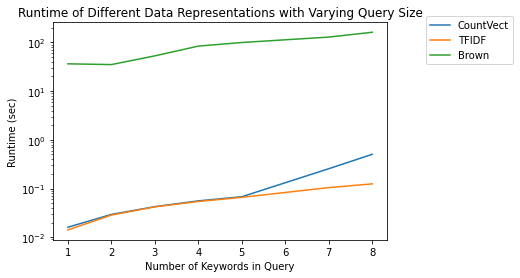

In [1]:
##### 1)Runtimes of different query sizes
import matplotlib.pyplot as plt
import numpy as np

querysize = np.array([1,2,3,4,5,7,8])

# countvect
countvect_avg_runtimes = np.array([.016008937358856203, .029333615303039552, .04240725040435791, .05571759939193725, .06778793334960938, .25505679845809937, .5044621229171753])
plt.plot(querysize, countvect_avg_runtimes, label="CountVect")

# tfidf
tfidf_avg_runtimes = np.array([.014100229740142823, .028435027599334715, .04196258783340454, .05409682989120483, .06580586433410644, .10441056489944459, .12457062005996704])
plt.plot(querysize, tfidf_avg_runtimes, label="TFIDF")

# brown
brown_avg_runtimes = np.array([36.43373328447342, 35.14559440612793, 53.08073705434799, 84.1618946313858, 99.85792083740235, 128.9931496977806, 162.24144197702407])
plt.plot(querysize, brown_avg_runtimes, label="Brown")

plt.yscale("log")
plt.title("Runtime of Different Data Representations with Varying Query Size")
plt.xlabel("Number of Keywords in Query")
plt.ylabel("Runtime (sec)")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

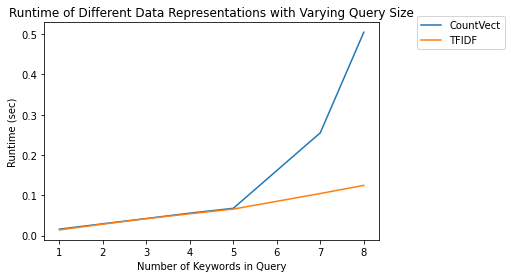

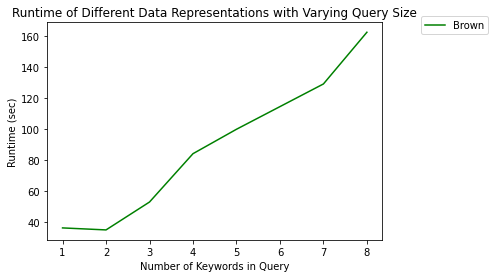

In [2]:
# TFIDF and countvect together
plt.plot(querysize, countvect_avg_runtimes, label="CountVect")
plt.plot(querysize, tfidf_avg_runtimes, label="TFIDF")
plt.title("Runtime of Different Data Representations with Varying Query Size")
plt.xlabel("Number of Keywords in Query")
plt.ylabel("Runtime (sec)")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

# Just brown
plt.plot(querysize, brown_avg_runtimes, label="Brown", color='green')
plt.title("Runtime of Different Data Representations with Varying Query Size")
plt.xlabel("Number of Keywords in Query")
plt.ylabel("Runtime (sec)")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

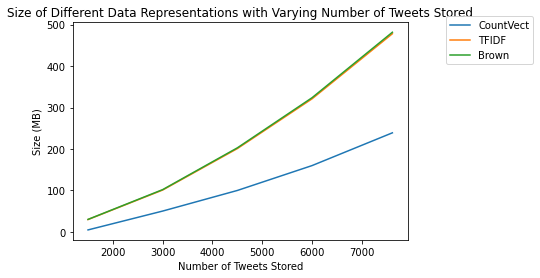

In [3]:
##### 2)Relationship between number of tweets and size of data representation

numTweets = np.array([1500, 3000, 4500, 6000, 7613])

# countvect
countvect_sizes = np.array([4.8, 50.3, 100, 160, 239])
plt.plot(numTweets, countvect_sizes, label="CountVect")

# tfidf
tfidf_sizes = np.array([29.8, 101, 201, 321, 478])
plt.plot(numTweets, tfidf_sizes, label="TFIDF")

# brown
brown_sizes = np.array([.35546875, 1.05, 1.83, 2.73, 3.6]) + tfidf_sizes
plt.plot(numTweets, brown_sizes, label="Brown")

plt.title("Size of Different Data Representations with Varying Number of Tweets Stored")
plt.xlabel("Number of Tweets Stored")
plt.ylabel("Size (MB)")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

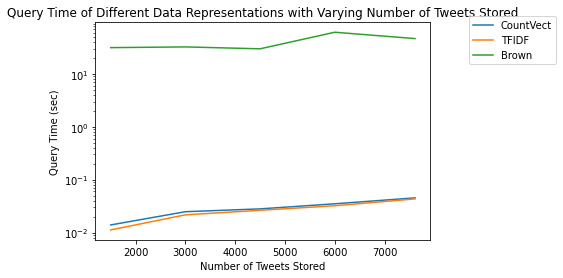

In [4]:
##### 3) Relationship between number of tweets and query time

numTweets = np.array([1500, 3000, 4500, 6000, 7613])

# countvect
countvect_avg_runtimes = np.array([.013947844505310059, .024823665618896484, .028082501888275147, .03503996133804321, .04536161422729492])
plt.plot(numTweets, countvect_avg_runtimes, label="CountVect")

# tfidf
tfidf_avg_runtimes = np.array([.011231791973114014, .02165952920913696, .026416730880737305, .03216578960418701, .04337368011474609])
plt.plot(numTweets, tfidf_avg_runtimes, label="TFIDF")

# brown
brown_avg_runtimes = np.array([31.487934696674348, 32.487717390060425, 29.90742540359497, 61.54061765670777, 46.681753146648404])
plt.plot(numTweets, brown_avg_runtimes, label="Brown")

plt.yscale("log")
plt.title("Query Time of Different Data Representations with Varying Number of Tweets Stored")
plt.xlabel("Number of Tweets Stored")
plt.ylabel("Query Time (sec)")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

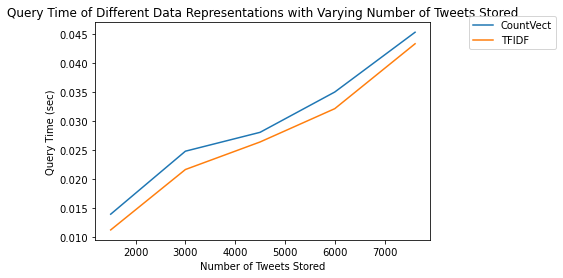

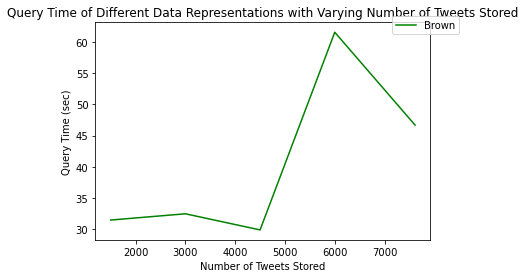

In [5]:
# TFIDF and countvect together
plt.plot(numTweets, countvect_avg_runtimes, label="CountVect")
plt.plot(numTweets, tfidf_avg_runtimes, label="TFIDF")
plt.title("Query Time of Different Data Representations with Varying Number of Tweets Stored")
plt.xlabel("Number of Tweets Stored")
plt.ylabel("Query Time (sec)")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

# Just brown
plt.plot(numTweets, brown_avg_runtimes, label="Brown", color='green')
plt.title("Query Time of Different Data Representations with Varying Number of Tweets Stored")
plt.xlabel("Number of Tweets Stored")
plt.ylabel("Query Time (sec)")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()